In [65]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm


Sets training configurations and loads the ProstateX labels. It ensures only patients with
corresponding preprocessed .npy volume files are included in the dataset.

In [67]:

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train.csv"
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load labels and volume paths ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)

# Only use IDs that have .npy files
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [68]:
#Functions

def resize_volume(vol, target_shape=(3, 64, 64, 64)):
    """
    Resizes a 4D volume by cropping or zero-padding to match the target shape.
    Ensures consistent input dimensions for model training.
    """
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    
    # Crop if too big
    d = min(d, td)
    h = min(h, th)
    w = min(w, tw)

    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

def load_tensor_dataset(dataframe, target_shape=(3, 64, 64, 64)):
    """
    Loads and resizes volumes from .npy files, stacks them into tensors,
    and returns a TensorDataset of image volumes and binary labels.
    """
    x_list, y_list = [], []
    for _, row in dataframe.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, target_shape)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))  # [N, 3, 64, 64, 64]
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor)


Splits the dataset into stratified training and validation sets based on ClinSig, loads them as tensor datasets, and prepares PyTorch DataLoaders for model training and evaluation.

In [70]:
# Split into train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)

train_data = load_tensor_dataset(train_df)
val_data = load_tensor_dataset(val_df)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

A simple 3D CNN for binary classification of prostate lesions is trained using binary cross-entropy loss. After each epoch, the training loss is printed, and the model learns to predict clinical significance from the preprocessed 3D volumes.

In [72]:
# === Define model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(32 * 16 * 16 * 16, 128),  # adjust if input shape is different
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(DEVICE)

# === Training ===
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Save model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")


Epoch 1/10: 100%|██████████| 66/66 [00:01<00:00, 44.94it/s]


Epoch 1 - Loss: 37.6334


Epoch 2/10: 100%|██████████| 66/66 [00:01<00:00, 47.47it/s]


Epoch 2 - Loss: 35.8395


Epoch 3/10: 100%|██████████| 66/66 [00:01<00:00, 45.54it/s]


Epoch 3 - Loss: 36.0578


Epoch 4/10: 100%|██████████| 66/66 [00:01<00:00, 47.52it/s]


Epoch 4 - Loss: 35.7906


Epoch 5/10: 100%|██████████| 66/66 [00:01<00:00, 47.95it/s]


Epoch 5 - Loss: 35.5140


Epoch 6/10: 100%|██████████| 66/66 [00:01<00:00, 48.29it/s]


Epoch 6 - Loss: 34.8291


Epoch 7/10: 100%|██████████| 66/66 [00:01<00:00, 46.95it/s]


Epoch 7 - Loss: 34.5192


Epoch 8/10: 100%|██████████| 66/66 [00:01<00:00, 47.49it/s]


Epoch 8 - Loss: 34.1947


Epoch 9/10: 100%|██████████| 66/66 [00:01<00:00, 48.71it/s]


Epoch 9 - Loss: 32.6661


Epoch 10/10: 100%|██████████| 66/66 [00:01<00:00, 48.53it/s]


Epoch 10 - Loss: 31.7896
 Model saved to C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth


Loads the saved 3D CNN model and evaluates its predictions on the validation set, calculating classification metrics like precision, recall, and F1-score for ClinSig and non-ClinSig cases.

In [74]:
# === Load saved model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === Evaluation ===
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        preds = model(x_batch).squeeze().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_preds += [int(preds)] if np.isscalar(preds) else preds.tolist()
        all_labels += [int(y_batch)] if torch.numel(y_batch) == 1 else y_batch.numpy().tolist()

print("\n Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"]))



 Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.78      0.96      0.86        51
     ClinSig       0.33      0.07      0.11        15

    accuracy                           0.76        66
   macro avg       0.56      0.51      0.49        66
weighted avg       0.68      0.76      0.69        66



Visualises the confusion matrix to assess how well the model distinguishes between clinically significant and non-significant lesions.

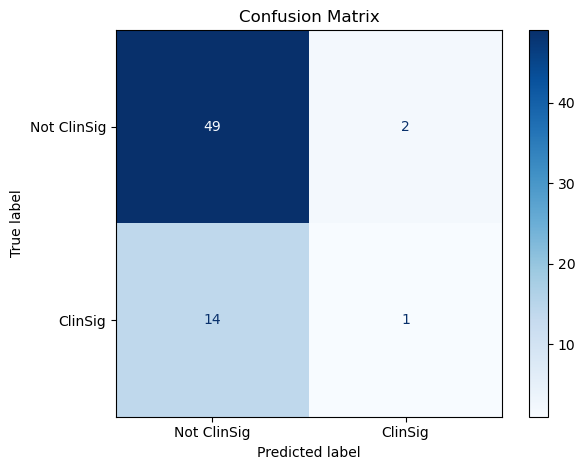

In [76]:
# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


<h2> Improving the model precision

Adding focal loss, data augmentation, and oversampling of clinically significant cases to handle class imbalance. It uses a deeper CNN architecture with batch normalization, dropout, and a learning rate scheduler for better generalisation

In [100]:

DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train.csv"
BATCH_SIZE = 4
EPOCHS = 200
LR = 1e-4
GAMMA = 3.0
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Focal Loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    """
    Computes Focal Loss to address class imbalance by focusing more on hard-to-classify examples.
    """
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Augmentation ===
def augment(volume):
    """
    Applies random 3D augmentations to a volume: horizontal flip, vertical flip, and 90-degree rotations.
    """
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)  # Horizontal
    if random.random() < 0.5:
        volume = np.flip(volume, axis=3)  # Vertical
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        volume = np.rot90(volume, k, axes=(2, 3)).copy()
    return volume

# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    """
    Resizes a volume to the target shape by cropping or zero-padding, with optional augmentation.
    """
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    """
    Loads volume data and labels into a TensorDataset, applying augmentation only to ClinSig-positive samples.
    Returns the dataset and associated patient IDs.
    """
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids

In [101]:

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [102]:
# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
clinsig_df = train_df[train_df['ClinSig'] == 1]
train_df = pd.concat([train_df, clinsig_df], ignore_index=True)

# === Display counts ===
print("Train class distribution:\n", train_df['ClinSig'].value_counts())
print("Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===
train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

Train class distribution:
 ClinSig
0    203
1    122
Name: count, dtype: int64
Val class distribution:
 ClinSig
0    51
1    15
Name: count, dtype: int64


A deep 3D CNN with batch normalization, dropout, and LeakyReLU activations, then trains it using focal loss and a learning rate scheduler. The model is optimised to handle class imbalance and learn robust features from volumetric prostate data.

Epoch 1/200: 100%|██████████| 82/82 [00:07<00:00, 11.44it/s]


Epoch 1 - Train Loss: 0.8429, Val Loss: 0.2941


Epoch 2/200: 100%|██████████| 82/82 [00:07<00:00, 11.42it/s]


Epoch 2 - Train Loss: 0.0865, Val Loss: 0.1167


Epoch 3/200: 100%|██████████| 82/82 [00:07<00:00, 11.32it/s]


Epoch 3 - Train Loss: 0.0632, Val Loss: 0.1091


Epoch 4/200: 100%|██████████| 82/82 [00:07<00:00, 11.37it/s]


Epoch 4 - Train Loss: 0.0506, Val Loss: 0.1316


Epoch 5/200: 100%|██████████| 82/82 [00:07<00:00, 11.35it/s]


Epoch 5 - Train Loss: 0.0514, Val Loss: 0.0889


Epoch 6/200: 100%|██████████| 82/82 [00:07<00:00, 11.30it/s]


Epoch 6 - Train Loss: 0.0438, Val Loss: 0.2081


Epoch 7/200: 100%|██████████| 82/82 [00:07<00:00, 11.16it/s]


Epoch 7 - Train Loss: 0.0653, Val Loss: 0.4255


Epoch 8/200: 100%|██████████| 82/82 [00:07<00:00, 11.29it/s]


Epoch 8 - Train Loss: 0.0697, Val Loss: 0.1262


Epoch 9/200: 100%|██████████| 82/82 [00:07<00:00, 11.17it/s]


Epoch 9 - Train Loss: 0.0394, Val Loss: 0.1576


Epoch 10/200: 100%|██████████| 82/82 [00:07<00:00, 11.24it/s]


Epoch 10 - Train Loss: 0.0363, Val Loss: 0.1712


Epoch 11/200: 100%|██████████| 82/82 [00:07<00:00, 10.81it/s]


Epoch 11 - Train Loss: 0.0434, Val Loss: 0.1608


Epoch 12/200: 100%|██████████| 82/82 [00:07<00:00, 11.11it/s]


Epoch 12 - Train Loss: 0.0341, Val Loss: 0.1602


Epoch 13/200: 100%|██████████| 82/82 [00:07<00:00, 11.29it/s]


Epoch 13 - Train Loss: 0.0269, Val Loss: 0.2178


Epoch 14/200: 100%|██████████| 82/82 [00:07<00:00, 11.40it/s]


Epoch 14 - Train Loss: 0.0270, Val Loss: 0.2302


Epoch 15/200: 100%|██████████| 82/82 [00:07<00:00, 11.36it/s]


Epoch 15 - Train Loss: 0.0190, Val Loss: 0.1911


Epoch 16/200: 100%|██████████| 82/82 [00:07<00:00, 11.32it/s]


Epoch 16 - Train Loss: 0.0190, Val Loss: 0.2941


Epoch 17/200: 100%|██████████| 82/82 [00:07<00:00, 11.08it/s]


Epoch 17 - Train Loss: 0.0242, Val Loss: 0.2343


Epoch 18/200: 100%|██████████| 82/82 [00:07<00:00, 11.26it/s]


Epoch 18 - Train Loss: 0.0212, Val Loss: 0.2738


Epoch 19/200: 100%|██████████| 82/82 [00:07<00:00, 11.16it/s]


Epoch 19 - Train Loss: 0.0183, Val Loss: 0.2763


Epoch 20/200: 100%|██████████| 82/82 [00:07<00:00, 11.09it/s]


Epoch 20 - Train Loss: 0.0219, Val Loss: 0.2593


Epoch 21/200: 100%|██████████| 82/82 [00:07<00:00, 11.20it/s]


Epoch 21 - Train Loss: 0.0207, Val Loss: 0.2238


Epoch 22/200: 100%|██████████| 82/82 [00:07<00:00, 11.19it/s]


Epoch 22 - Train Loss: 0.0175, Val Loss: 0.2829


Epoch 23/200: 100%|██████████| 82/82 [00:07<00:00, 11.34it/s]


Epoch 23 - Train Loss: 0.0182, Val Loss: 0.2395


Epoch 24/200: 100%|██████████| 82/82 [00:07<00:00, 11.37it/s]


Epoch 24 - Train Loss: 0.0158, Val Loss: 0.2514


Epoch 25/200: 100%|██████████| 82/82 [00:07<00:00, 11.47it/s]


Epoch 25 - Train Loss: 0.0167, Val Loss: 0.2394


Epoch 26/200: 100%|██████████| 82/82 [00:07<00:00, 11.35it/s]


Epoch 26 - Train Loss: 0.0145, Val Loss: 0.2693


Epoch 27/200: 100%|██████████| 82/82 [00:07<00:00, 11.37it/s]


Epoch 27 - Train Loss: 0.0154, Val Loss: 0.2486


Epoch 28/200: 100%|██████████| 82/82 [00:07<00:00, 11.31it/s]


Epoch 28 - Train Loss: 0.0177, Val Loss: 0.2680


Epoch 29/200: 100%|██████████| 82/82 [00:07<00:00, 11.40it/s]


Epoch 29 - Train Loss: 0.0181, Val Loss: 0.2575


Epoch 30/200: 100%|██████████| 82/82 [00:07<00:00, 11.39it/s]


Epoch 30 - Train Loss: 0.0181, Val Loss: 0.2685


Epoch 31/200: 100%|██████████| 82/82 [00:07<00:00, 11.45it/s]


Epoch 31 - Train Loss: 0.0167, Val Loss: 0.2532


Epoch 32/200: 100%|██████████| 82/82 [00:07<00:00, 11.34it/s]


Epoch 32 - Train Loss: 0.0153, Val Loss: 0.2686


Epoch 33/200: 100%|██████████| 82/82 [00:07<00:00, 11.38it/s]


Epoch 33 - Train Loss: 0.0190, Val Loss: 0.2746


Epoch 34/200: 100%|██████████| 82/82 [00:07<00:00, 11.40it/s]


Epoch 34 - Train Loss: 0.0152, Val Loss: 0.2930


Epoch 35/200: 100%|██████████| 82/82 [00:07<00:00, 11.39it/s]


Epoch 35 - Train Loss: 0.0174, Val Loss: 0.2611


Epoch 36/200: 100%|██████████| 82/82 [00:07<00:00, 11.36it/s]


Epoch 36 - Train Loss: 0.0150, Val Loss: 0.2283


Epoch 37/200: 100%|██████████| 82/82 [00:07<00:00, 11.43it/s]


Epoch 37 - Train Loss: 0.0197, Val Loss: 0.2398


Epoch 38/200: 100%|██████████| 82/82 [00:07<00:00, 11.38it/s]


Epoch 38 - Train Loss: 0.0163, Val Loss: 0.2602


Epoch 39/200: 100%|██████████| 82/82 [00:07<00:00, 11.39it/s]


Epoch 39 - Train Loss: 0.0162, Val Loss: 0.2822


Epoch 40/200: 100%|██████████| 82/82 [00:07<00:00, 11.44it/s]


Epoch 40 - Train Loss: 0.0180, Val Loss: 0.2733


Epoch 41/200: 100%|██████████| 82/82 [00:07<00:00, 11.32it/s]


Epoch 41 - Train Loss: 0.0238, Val Loss: 0.2911


Epoch 42/200: 100%|██████████| 82/82 [00:07<00:00, 11.30it/s]


Epoch 42 - Train Loss: 0.0161, Val Loss: 0.2953


Epoch 43/200: 100%|██████████| 82/82 [00:07<00:00, 11.25it/s]


Epoch 43 - Train Loss: 0.0163, Val Loss: 0.2543


Epoch 44/200: 100%|██████████| 82/82 [00:07<00:00, 11.43it/s]


Epoch 44 - Train Loss: 0.0153, Val Loss: 0.2708


Epoch 45/200: 100%|██████████| 82/82 [00:07<00:00, 11.40it/s]


Epoch 45 - Train Loss: 0.0177, Val Loss: 0.2486


Epoch 46/200: 100%|██████████| 82/82 [00:07<00:00, 11.41it/s]


Epoch 46 - Train Loss: 0.0179, Val Loss: 0.2580


Epoch 47/200: 100%|██████████| 82/82 [00:07<00:00, 11.35it/s]


Epoch 47 - Train Loss: 0.0185, Val Loss: 0.2718


Epoch 48/200: 100%|██████████| 82/82 [00:07<00:00, 11.52it/s]


Epoch 48 - Train Loss: 0.0154, Val Loss: 0.2550


Epoch 49/200: 100%|██████████| 82/82 [00:07<00:00, 11.39it/s]


Epoch 49 - Train Loss: 0.0161, Val Loss: 0.2558


Epoch 50/200: 100%|██████████| 82/82 [00:07<00:00, 11.50it/s]


Epoch 50 - Train Loss: 0.0179, Val Loss: 0.2908


Epoch 51/200: 100%|██████████| 82/82 [00:07<00:00, 11.50it/s]


Epoch 51 - Train Loss: 0.0156, Val Loss: 0.2864


Epoch 52/200: 100%|██████████| 82/82 [00:07<00:00, 11.55it/s]


Epoch 52 - Train Loss: 0.0178, Val Loss: 0.2935


Epoch 53/200: 100%|██████████| 82/82 [00:07<00:00, 11.52it/s]


Epoch 53 - Train Loss: 0.0184, Val Loss: 0.2787


Epoch 54/200: 100%|██████████| 82/82 [00:07<00:00, 11.53it/s]


Epoch 54 - Train Loss: 0.0165, Val Loss: 0.2526


Epoch 55/200: 100%|██████████| 82/82 [00:07<00:00, 11.53it/s]


Epoch 55 - Train Loss: 0.0187, Val Loss: 0.2870
Early stopping at epoch 55
 Model saved to C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth


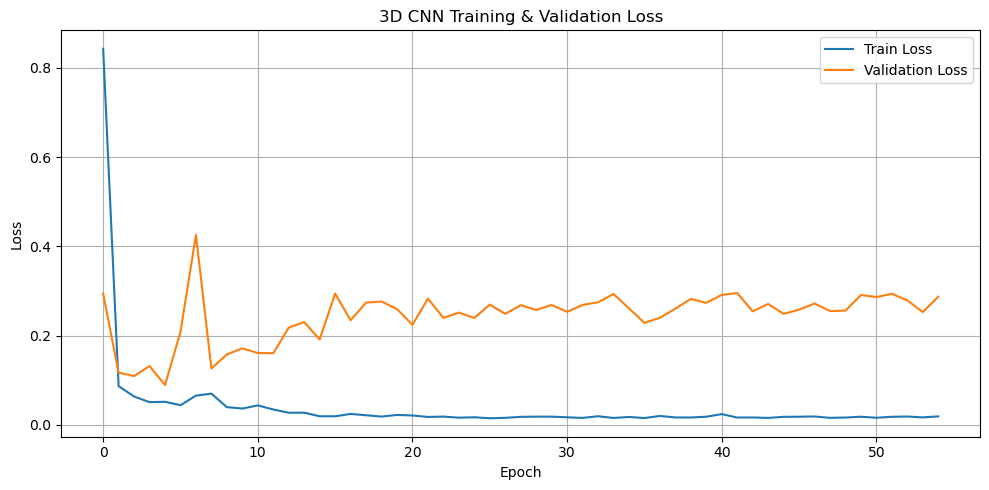

In [114]:
# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)

# === Optimizer and Scheduler ===
optimizer = optim.Adam(model.parameters(), lr=LR) # Adam optimizer for adaptive learning
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5) # Reduce LR on plateau

# === Early Stopping Setup ===
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 50

train_losses = []
val_losses = []
# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze(dim=-1)
        loss = focal_loss(logits, y_batch)  # Using Focal Loss to handle class imbalance
        loss.backward()
        optimizer.step()
        total_train_loss  += loss.item()
    train_losses.append(total_train_loss / len(train_loader))
    # === Validation Phase ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            val_logits = model(x_val).squeeze(dim=-1)
            val_loss = focal_loss(val_logits, y_val)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss)
    
    # === Check for Early Stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_path = r"C:\Users\anude\Downloads\project\best_prostate_3dcnn.pth"
        torch.save(model.state_dict(),best_model_path )
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# === Save Final Trained Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")


# === Plot Training and Validation Loss Curves ===
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("3D CNN Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_3dcnn.png")
plt.show()

Evaluates the final and best model on the validation set using sigmoid-based thresholding and prints a classification report, displays example predictions.


 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.78      0.75      0.76        51
     ClinSig       0.24      0.27      0.25        15

    accuracy                           0.64        66
   macro avg       0.51      0.51      0.51        66
weighted avg       0.65      0.64      0.64        66


 Sample Predictions:
ProstateX-0190: Predicted=1, Actual=0
ProstateX-0052: Predicted=1, Actual=0
ProstateX-0012: Predicted=0, Actual=0
ProstateX-0160: Predicted=0, Actual=0
ProstateX-0065: Predicted=0, Actual=0
ProstateX-0079: Predicted=0, Actual=0
ProstateX-0088: Predicted=1, Actual=0
ProstateX-0021: Predicted=0, Actual=0
ProstateX-0136: Predicted=0, Actual=0
ProstateX-0110: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

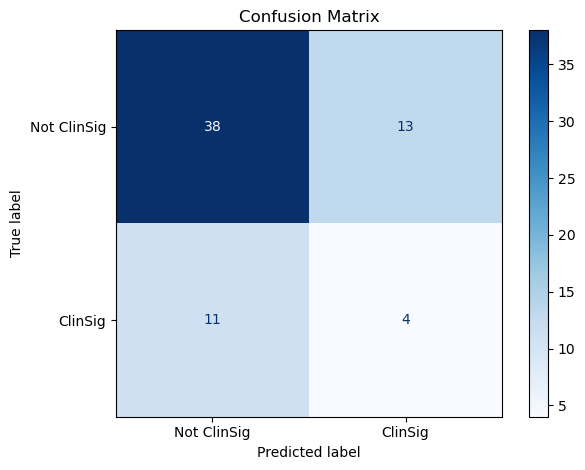

In [116]:
# === Load Saved Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.76      0.76      0.76        51
     ClinSig       0.20      0.20      0.20        15

    accuracy                           0.64        66
   macro avg       0.48      0.48      0.48        66
weighted avg       0.64      0.64      0.64        66


 Sample Predictions:
ProstateX-0190: Predicted=1, Actual=0
ProstateX-0052: Predicted=1, Actual=0
ProstateX-0012: Predicted=0, Actual=0
ProstateX-0160: Predicted=0, Actual=0
ProstateX-0065: Predicted=0, Actual=0
ProstateX-0079: Predicted=0, Actual=0
ProstateX-0088: Predicted=1, Actual=0
ProstateX-0021: Predicted=1, Actual=0
ProstateX-0136: Predicted=0, Actual=0
ProstateX-0110: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

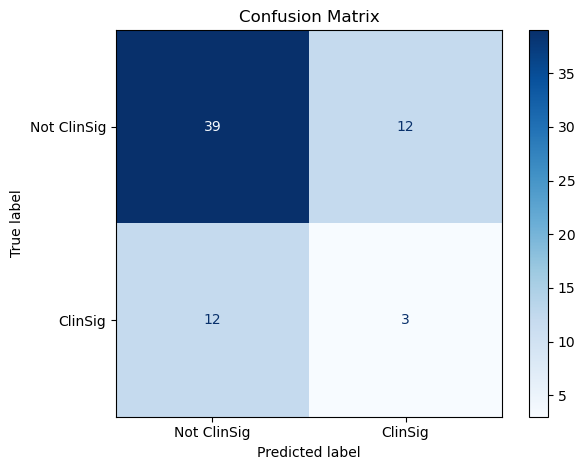

In [117]:
# === Load Saved Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\best_prostate_3dcnn.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()